In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from fuzzywuzzy import process
import re
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Normalization
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers


def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text.strip())


def eliminate_double_characters(text):
    # Initialize an empty string to store the processed text
    processed_text = ""
    
    # Iterate through the characters of the input text
    i = 0
    while i < len(text):
        # Append the current character to the processed text
        processed_text += text[i]
        
        # Check if the current character is repeated consecutively
        if i + 1 < len(text) and text[i] == text[i + 1]:
            # Move to the next character skipping the consecutive duplicates
            while i + 1 < len(text) and text[i] == text[i + 1]:
                i += 1
        # Move to the next character
        i += 1
    
    return processed_text


def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

def closest_word(text, dataset_texts):
    highest_similarity_score = 0
    closest_match = None
    for word in text.split():
        closest_match_for_word, similarity_score = process.extractOne(word, dataset_texts)
        if similarity_score > highest_similarity_score:
            highest_similarity_score = similarity_score
            closest_match = closest_match_for_word
    return closest_match, highest_similarity_score

def preprocess(df, dataset_texts):
    df['Deskripsi'] = df['Deskripsi'].apply(remove_extra_spaces)
    df['Deskripsi'] = df['Deskripsi'].apply(normalize_text)
    df['Deskripsi'] = df['Deskripsi'].apply(eliminate_double_characters)
    
    closest_words = []
    closest_words_num = []
    closest_words_score = []
    for sentence in df['Deskripsi']:
        closest_match, similarity_score = closest_word(sentence, dataset_texts)
        if similarity_score < 20:
            closest_word_num = 0
            closest_match = "missing"
        else:
            closest_word_num = dataset_texts.index(closest_match) + 1
        closest_words.append(closest_match)
        closest_words_num.append(closest_word_num)
        closest_words_score.append(similarity_score)
    
    df['closest_words'] = closest_words
    df['closest_words_num'] = closest_words_num
    df['score'] = closest_words_score
    
    return df

2024-04-12 18:51:09.440164: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 18:51:09.489662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 18:51:09.489705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 18:51:09.490984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 18:51:09.498443: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 18:51:09.499479: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Load the DataFrame
df = pd.read_csv('dummy2.csv')

# Example dataset_texts
dataset_texts = ["shf", "settlement", "fidusia", "pinalty", "umk"]

# Preprocess the data
df = preprocess(df, dataset_texts)

In [3]:
target = df.pop('Verifikasi')

In [4]:
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

In [5]:
numeric_feature_names = ['closest_words_num', 'Nominal']
numeric_features = df[numeric_feature_names]
numeric_features = tf.convert_to_tensor(numeric_features)

In [6]:
numeric_feature_name = ['closest_words_num']
numeric_features_one = df[numeric_feature_name]
numeric_features_one = tf.convert_to_tensor(numeric_features_one)

In [7]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(numeric_features)


In [8]:
horsepower = np.array(numeric_features_one)

horsepower_normalizer = tf.keras.layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [9]:
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        Dense(2, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dense(16, activation='relu'),
        Dense(64, activation='relu'),
        Dense(len(label_encoder.classes_), activation='softmax')

    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(0.01),
                  metrics=['accuracy'])
    return model

In [10]:
model = build_and_compile_model(normalizer)

In [11]:
#model.fit(numeric_features, target, epochs=100, batch_size=8)

In [12]:
checkpoint_callback = ModelCheckpoint(
    filepath="./model",
    monitor='val_accuracy',
    save_best_only=True,  # Save only the best model weights
    verbose=1,  # Verbosity mode. Set to 1 to see the messages.
    save_weights_only=False,  # Save the entire model (including architecture, weights, and optimizer state)
)

In [13]:
%%time
history = model.fit(
    numeric_features,
    target_encoded,
    epochs=250,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.3,
    callbacks=[checkpoint_callback])


Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 2: val_accuracy improved from 0.48000 to 0.55200, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 3: val_accuracy did not improve from 0.55200

Epoch 4: val_accuracy improved from 0.55200 to 0.62400, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 5: val_accuracy improved from 0.62400 to 0.69600, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 6: val_accuracy did not improve from 0.69600

Epoch 7: val_accuracy did not improve from 0.69600

Epoch 8: val_accuracy did not improve from 0.69600

Epoch 9: val_accuracy did not improve from 0.69600

Epoch 10: val_accuracy did not improve from 0.69600

Epoch 11: val_accuracy improved from 0.69600 to 0.71200, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 12: val_accuracy did not improve from 0.71200

Epoch 13: val_accuracy did not improve from 0.71200

Epoch 14: val_accuracy did not improve from 0.71200

Epoch 15: val_accuracy did not improve from 0.71200

Epoch 16: val_accuracy improved from 0.71200 to 0.72800, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 17: val_accuracy improved from 0.72800 to 0.75200, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 18: val_accuracy did not improve from 0.75200

Epoch 19: val_accuracy did not improve from 0.75200

Epoch 20: val_accuracy did not improve from 0.75200

Epoch 21: val_accuracy improved from 0.75200 to 0.76800, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 22: val_accuracy did not improve from 0.76800

Epoch 23: val_accuracy did not improve from 0.76800

Epoch 24: val_accuracy did not improve from 0.76800

Epoch 25: val_accuracy did not improve from 0.76800

Epoch 26: val_accuracy did not improve from 0.76800

Epoch 27: val_accuracy did not improve from 0.76800

Epoch 28: val_accuracy improved from 0.76800 to 0.87200, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 29: val_accuracy did not improve from 0.87200

Epoch 30: val_accuracy did not improve from 0.87200

Epoch 31: val_accuracy did not improve from 0.87200

Epoch 32: val_accuracy did not improve from 0.87200

Epoch 33: val_accuracy improved from 0.87200 to 0.89600, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 34: val_accuracy did not improve from 0.89600

Epoch 35: val_accuracy did not improve from 0.89600

Epoch 36: val_accuracy did not improve from 0.89600

Epoch 37: val_accuracy did not improve from 0.89600

Epoch 38: val_accuracy did not improve from 0.89600

Epoch 39: val_accuracy did not improve from 0.89600

Epoch 40: val_accuracy did not improve from 0.89600

Epoch 41: val_accuracy did not improve from 0.89600

Epoch 42: val_accuracy did not improve from 0.89600

Epoch 43: val_accuracy did not improve from 0.89600

Epoch 44: val_accuracy did not improve from 0.89600

Epoch 45: val_accuracy did not improve from 0.89600

Epoch 46: val_accuracy improved from 0.89600 to 0.90400, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 47: val_accuracy improved from 0.90400 to 0.92800, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 48: val_accuracy improved from 0.92800 to 0.94400, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 49: val_accuracy did not improve from 0.94400

Epoch 50: val_accuracy did not improve from 0.94400

Epoch 51: val_accuracy did not improve from 0.94400

Epoch 52: val_accuracy did not improve from 0.94400

Epoch 53: val_accuracy improved from 0.94400 to 0.95200, saving model to ./model
INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets



Epoch 54: val_accuracy did not improve from 0.95200

Epoch 55: val_accuracy did not improve from 0.95200

Epoch 56: val_accuracy did not improve from 0.95200

Epoch 57: val_accuracy did not improve from 0.95200

Epoch 58: val_accuracy did not improve from 0.95200

Epoch 59: val_accuracy did not improve from 0.95200

Epoch 60: val_accuracy did not improve from 0.95200

Epoch 61: val_accuracy did not improve from 0.95200

Epoch 62: val_accuracy did not improve from 0.95200

Epoch 63: val_accuracy did not improve from 0.95200

Epoch 64: val_accuracy did not improve from 0.95200

Epoch 65: val_accuracy did not improve from 0.95200

Epoch 66: val_accuracy did not improve from 0.95200

Epoch 67: val_accuracy did not improve from 0.95200

Epoch 68: val_accuracy did not improve from 0.95200

Epoch 69: val_accuracy did not improve from 0.95200

Epoch 70: val_accuracy did not improve from 0.95200

Epoch 71: val_accuracy did not improve from 0.95200

Epoch 72: val_accuracy did not improve from 0

INFO:tensorflow:Assets written to: ./model/assets



Epoch 76: val_accuracy did not improve from 0.96800

Epoch 77: val_accuracy did not improve from 0.96800

Epoch 78: val_accuracy did not improve from 0.96800

Epoch 79: val_accuracy did not improve from 0.96800

Epoch 80: val_accuracy did not improve from 0.96800

Epoch 81: val_accuracy did not improve from 0.96800

Epoch 82: val_accuracy did not improve from 0.96800

Epoch 83: val_accuracy did not improve from 0.96800

Epoch 84: val_accuracy did not improve from 0.96800

Epoch 85: val_accuracy did not improve from 0.96800

Epoch 86: val_accuracy did not improve from 0.96800

Epoch 87: val_accuracy did not improve from 0.96800

Epoch 88: val_accuracy did not improve from 0.96800

Epoch 89: val_accuracy did not improve from 0.96800

Epoch 90: val_accuracy did not improve from 0.96800

Epoch 91: val_accuracy did not improve from 0.96800

Epoch 92: val_accuracy did not improve from 0.96800

Epoch 93: val_accuracy did not improve from 0.96800

Epoch 94: val_accuracy did not improve from 0

INFO:tensorflow:Assets written to: ./model/assets



Epoch 242: val_accuracy did not improve from 0.97600

Epoch 243: val_accuracy did not improve from 0.97600

Epoch 244: val_accuracy did not improve from 0.97600

Epoch 245: val_accuracy did not improve from 0.97600

Epoch 246: val_accuracy did not improve from 0.97600

Epoch 247: val_accuracy did not improve from 0.97600

Epoch 248: val_accuracy did not improve from 0.97600

Epoch 249: val_accuracy did not improve from 0.97600

Epoch 250: val_accuracy did not improve from 0.97600
CPU times: user 28.1 s, sys: 2.38 s, total: 30.4 s
Wall time: 26 s


In [14]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
245,0.211945,0.914089,0.399413,0.848,245
246,0.217578,0.917526,0.308801,0.880,246
247,0.165219,0.941581,0.159532,0.944,247
248,0.116208,0.962199,0.151458,0.960,248
249,0.117781,0.958763,0.131485,0.944,249


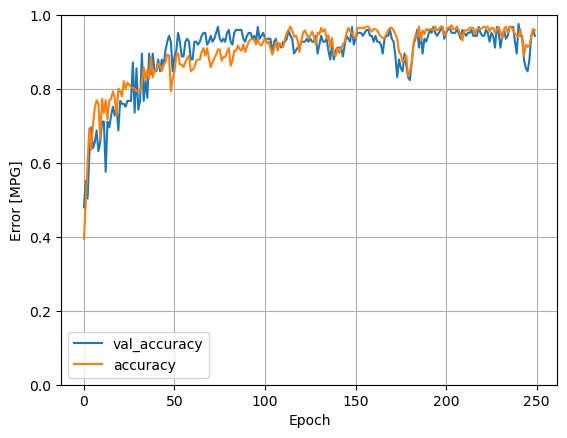

In [15]:
def plot_loss(history):
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [16]:
specific_rows = hist.iloc[13:]
specific_rows

,loss,accuracy,val_loss,val_accuracy,epoch
13,0.732791,0.718213,0.777265,0.712,13
14,0.707612,0.769759,0.835876,0.696,14
15,0.692625,0.773196,0.752774,0.728,15
16,0.642645,0.793814,0.661869,0.752,16
17,0.643145,0.776632,0.671675,0.728,17
...,...,...,...,...,...
245,0.211945,0.914089,0.399413,0.848,245
246,0.217578,0.917526,0.308801,0.880,246
247,0.165219,0.941581,0.159532,0.944,247
248,0.116208,0.962199,0.151458,0.960,248


In [17]:
def preprocess_input(deskripsi, nominal, dataset_texts):
    # Normalize deskripsi
    deskripsi = remove_extra_spaces(deskripsi)
    deskripsi = normalize_text(deskripsi)
    
    # Find the closest word and its number
    closest_match, _ = closest_word(deskripsi, dataset_texts)
    closest_word_num = dataset_texts.index(closest_match) + 1 if closest_match else 0
    
    # Normalize nominal
    nominal = nominal   # Assuming your training data was also scaled
    
    return np.array([[closest_word_num, nominal]], dtype=np.float32)

# Example input
deskripsi = "abcabcabc"
nominal = 450000

# Preprocess input
input_data = preprocess_input(deskripsi, nominal, dataset_texts)


In [18]:
# Predict using the model
predictions = model.predict(input_data)

# Decode the predicted labels
predicted_label = label_encoder.inverse_transform([np.argmax(predictions)])

print("Predicted label:", predicted_label)


1/1 [==============================] - 0s 97ms/step
Predicted label: ['Fidusia']


In [20]:
# Load the SavedModel
loaded_model = tf.keras.models.load_model('model')

# Save the model to HDF5 format
loaded_model.save('model.h5')

/home/gusanwa/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
